# BEES1041 Exploring the Natural World #
# Week 2 Computer Exercise - Linear models and vegetation structure #
***
This week notebook 

Why look at relationships between


<br><br>
***
The...

In [4]:
ausplots_data <- read.csv('ausplot_forest_data.csv')
colnames(ausplots_data)
nrow(ausplots_data)

[1] "ID"                     "Ausplot_ID"             "Site_Name"             
 [4] "Date"                   "Subplot"                "Tree_ID"               
 [7] "Genus_Species"          "Tree_Condition"         "Tree_Status"           
[10] "Mode_Of_Death"          "Growth_Stage"           "Crown_Class"           
[13] "Diameter"               "Point_Of_Measurement"   "Diameter_2"            
[16] "Point_Of_Measurement_2" "Height"                 "Bole_Height"           
[19] "Height_Of_Break"        "Historic_ID"            "Comment"

[1] 24512

Select only alive trees, where the diameter was measured at 1.3 m, and diameter and height were measured. 

In [5]:
ausplots_subset <- subset(ausplots_data,
                          (Point_Of_Measurement == 1.3) &
                          (Diameter > 0) &
                          (Height > 0) &
                          (Tree_Status == 'A'))
nrow(ausplots_subset)

[1] 2752

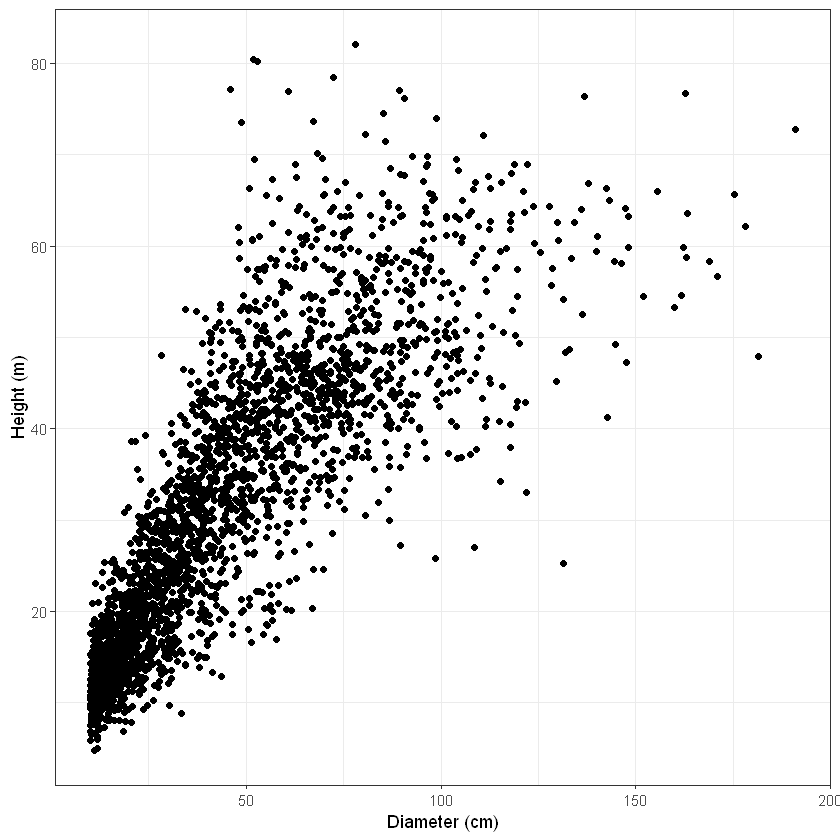

In [6]:
library(ggplot2)
ggplot(ausplots_subset, aes(x = Diameter, y = Height)) +
       geom_point() +
       labs(x = "Diameter (cm)", y = "Height (m)") +
       theme_bw()

Firstly, the data has no locaion information, so we need to merge the dataframe with another dataset

In [8]:
ausplots_locations <- read.csv('ausplot_forest_locations.csv')
colnames(ausplots_locations)

[1] "Ausplot_ID" "longitude"  "latitude"

In [14]:
library(dplyr)
ausplots_subset <- inner_join(ausplots_subset, ausplots_locations)
colnames(ausplots_subset)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Joining, by = "Ausplot_ID"
Warning message:
"Column `Ausplot_ID` joining factors with different levels, coercing to character vector"

[1] "Ausplot_ID"             "ID"                     "Site_Name"             
 [4] "Date"                   "Subplot"                "Tree_ID"               
 [7] "Genus_Species"          "Tree_Condition"         "Tree_Status"           
[10] "Mode_Of_Death"          "Growth_Stage"           "Crown_Class"           
[13] "Diameter"               "Point_Of_Measurement"   "Diameter_2"            
[16] "Point_Of_Measurement_2" "Height"                 "Bole_Height"           
[19] "Height_Of_Break"        "Historic_ID"            "Comment"               
[22] "longitude.x"            "latitude.x"             "longitude.y"           
[25] "latitude.y"             "longitude"              "latitude"

[1] -30.15757

## Questions to answer ##

How well have the trees of Australia been sampled?
- Distribution of heights?
- Dates?
- Genus?

What is the linear relationship between height and diameter?
- intercept and slope?
- R2?
- RMSE?

How similar is the Sydney tree data?

Comparison of Sydney tree data with lidar data?